# Project Luther - Kalgi Shah
### Date: 7th Oct'17

In [1]:
#importing all the modules used for the project
import re
import pandas as pd
import csv
import time
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
import dateutil.parser as dparser
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso

%matplotlib inline

# Scraped weather data for different dates and stored it as csv's in the local machine.
# Converting all variables in the int/float format by striping it as well as conversions to datetime.
def get_weather_df():
    path =r'/home/kalgi/ds/metis/projects/Luther/scraping/' # use your path
    allFiles = glob.glob(path + "*")
    weather = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0, sep='\t')
        list_.append(df)
    weather = pd.concat(list_)

    weather['Time'] = weather.apply(lambda row: row['Time (EDT)'] if pd.notnull(row['Time (EDT)']) else row['Time (EST)'], axis=1)
    weather['DATE&TIME'] = weather['date'] + " " + weather['Time']
    weather['DATETIME'] = pd.to_datetime(weather['DATE&TIME'], format='%Y-%m-%d %H:%M %p')
    weather = weather.filter(['Conditions','Dew Point','Humidity','Pressure','Temp.','Visibility','DATETIME'], axis=1).copy()
    weather['Visibility'] = weather['Visibility'].apply(lambda x: x.rstrip('mi'))
    weather['Dew Point'] = weather['Dew Point'].apply(lambda x: x.rstrip('°F'))
    weather['Pressure'] = weather['Pressure'].apply(lambda x: x.rstrip('in'))
    weather['Temp.'] = weather['Temp.'].apply(lambda x: x.rstrip('°F'))
    weather['Humidity'] = weather['Humidity'].apply(lambda x: x.rstrip('%'))
    weather['DATETIME'] = weather.DATETIME.apply(lambda x: pd.datetime(x.year, x.month, x.day, x.hour))
    weather['Time_Hour'] = weather['DATETIME'].dt.hour
    #start_date = pd.to_datetime('09/01/2015')
    #end_date = pd.to_datetime('09/01/2016')
    #weather_small = weather[(weather['DATETIME'] >= start_date) & (weather['DATETIME'] <= end_date)]
    return weather

# Function defined to read traffic incidents data from the csv stored in the local machine and merging some features and basic cleaning for data
def get_incidents_df():
    raw_incidents = pd.read_csv('/home/kalgi/ds/metis/projects/Luther/NYPD_Motor_Vehicle_Collisions.csv')
    traffic_incidents = raw_incidents.filter(['DATE','TIME','BOROUGH','ZIP CODE','LATITUDE','LONGITUDE','LOCATION','NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED','NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED'], axis=1).copy()
    traffic_incidents['DATE&TIME'] = traffic_incidents['DATE'] + " " + traffic_incidents['TIME']
    traffic_incidents['DATETIME'] = pd.to_datetime(traffic_incidents['DATE&TIME'], format='%m/%d/%Y %H:%M')
    traffic_incidents['DATETIME'] = traffic_incidents.DATETIME.map(lambda x: pd.datetime(x.year, x.month, x.day, x.hour))
    traffic_incidents['INCIDENT_COUNT'] = traffic_incidents['NUMBER OF PERSONS INJURED'] + traffic_incidents['NUMBER OF PERSONS KILLED']
    traffic_incidents['PEDESTRIAN_COUNT'] = traffic_incidents['NUMBER OF PEDESTRIANS INJURED'] + traffic_incidents['NUMBER OF PEDESTRIANS KILLED']
    traffic_incidents['CYCLIST_COUNT'] = traffic_incidents['NUMBER OF CYCLIST INJURED'] + traffic_incidents['NUMBER OF CYCLIST KILLED']
    traffic_incidents['MOTORIST_COUNT'] = traffic_incidents['NUMBER OF MOTORIST INJURED'] + traffic_incidents['NUMBER OF MOTORIST KILLED']
    #start_date = pd.to_datetime('09/01/2016')
    #end_date = pd.to_datetime('12/01/2016')
    #traffic_incidents_small = traffic_incidents[(traffic_incidents['DATETIME'] >= start_date) & (traffic_incidents['DATETIME'] <= end_date)]
    return traffic_incidents

/home/kalgi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Function calls for both datasets
weather = get_weather_df()
incidents = get_incidents_df()

incidents['INCIDENT_COUNT_rebased'] = incidents['INCIDENT_COUNT'].apply(lambda x:x+1)
# incidents = incidents[(incidents['INCIDENT_COUNT'] > 0)]

incident_weather = pd.merge(incidents,weather, on='DATETIME',how = 'inner')


/home/kalgi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [21]:
# Converting all features to numeric
incident_weather['Visibility'] = pd.to_numeric(incident_weather['Visibility'], errors='coerce')
incident_weather['Dew Point'] = pd.to_numeric(incident_weather['Dew Point'], errors='coerce')
incident_weather['Pressure'] = pd.to_numeric(incident_weather['Pressure'], errors='coerce')
incident_weather['Temp.'] = pd.to_numeric(incident_weather['Temp.'], errors='coerce')
incident_weather['Humidity'] = pd.to_numeric(incident_weather['Humidity'], errors='coerce')

incident_weather.dropna(axis=0,how='any',subset=['Visibility','Dew Point', 'Pressure', 'Temp.','Humidity'], inplace=True)
len(incident_weather)

193545

In [4]:
# Combining features for simplicity  
combined = pd.get_dummies(data = incident_weather, columns = ['Conditions'])
combined['snow'] = combined.apply(lambda row: 1 if (row['Conditions_Heavy Snow'] == 1) else 0, axis=1)
combined['rains'] = combined.apply(lambda row: 1 if (row['Conditions_Heavy Rain'] == 1) else 0, axis=1)
combined['light_snow'] = combined.apply(lambda row: 1 if (row['Conditions_Light Snow'] == 1 or row['Conditions_Snow'] == 1) else 0, axis=1)
combined['light_rains'] = combined.apply(lambda row: 1 if (row['Conditions_Light Rain'] == 1 or row['Conditions_Rain'] == 1) else 0, axis=1)

In [5]:
#Defining variables for linear regression
x = ['Visibility','Dew Point','Pressure','Temp.','snow', 'rains', 'light_snow', 'light_rains', 'Conditions_Haze']
y = ['INCIDENT_COUNT','PEDESTRIAN_COUNT','CYCLIST_COUNT','MOTORIST_COUNT','INCIDENT_COUNT_rebased']
group = ['DATETIME','BOROUGH', 'LATITUDE', 'LONGITUDE']
filtered = combined[group + x+y]

In [6]:
# Aggregation on features
agg_map = {
    'Visibility' : np.mean,
    'Dew Point' : np.mean,
    'Pressure'  : np.mean,
    'Temp.' : np.mean,
#    'Humidity' : np.mean,
    'light_snow' : np.mean,
    'light_rains' : np.mean,
    'snow'  : np.max,
    'rains'  : np.max,
    'Conditions_Haze' : np.max,
    'INCIDENT_COUNT': np.sum,
    'PEDESTRIAN_COUNT': np.sum,
    'CYCLIST_COUNT': np.sum,
    'MOTORIST_COUNT': np.sum,
    'INCIDENT_COUNT_rebased': np.sum
}
aggregated = filtered.groupby(group, as_index=False).agg(agg_map)

In [7]:
# Filtering visibility data
filtered_agg = aggregated[aggregated['Visibility'] > 1]
filtered_agg.columns

Index(['DATETIME', 'BOROUGH', 'LATITUDE', 'LONGITUDE', 'Visibility',
       'Dew Point', 'Pressure', 'Temp.', 'light_snow', 'light_rains', 'snow',
       'rains', 'Conditions_Haze', 'INCIDENT_COUNT', 'PEDESTRIAN_COUNT',
       'CYCLIST_COUNT', 'MOTORIST_COUNT', 'INCIDENT_COUNT_rebased'],
      dtype='object')

In [8]:
filtered_agg.corr()["INCIDENT_COUNT"]

LATITUDE                 -0.028023
LONGITUDE                 0.037885
Visibility               -0.099322
Dew Point                 0.037791
Pressure                 -0.029136
Temp.                     0.006797
light_snow                0.035297
light_rains               0.072938
snow                           NaN
rains                     0.061200
Conditions_Haze           0.022952
INCIDENT_COUNT            1.000000
PEDESTRIAN_COUNT          0.339736
CYCLIST_COUNT             0.171857
MOTORIST_COUNT            0.880574
INCIDENT_COUNT_rebased    0.857264
Name: INCIDENT_COUNT, dtype: float64

In [ ]:
# Potting coloured pairplot based on Boroughs
sns.pairplot(filtered_agg, x_vars = x, y_vars = y, kind = 'reg', hue = 'BOROUGH')

## Linear Regression

In [9]:
X=filtered_agg.loc[:,x]
y=filtered_agg['INCIDENT_COUNT_rebased']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=45)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lars_path

# from matplotlib import pyplot as plt
# std = StandardScaler()
# std.fit(X_train)
# X_tr = std.transform(X_train)
# X_te = std.transform(X_test)


model_lr_log = LinearRegression()
model_lr_log.fit(X_train, y_train)
pred_vals_lr_log = np.exp(model_lr_log.predict(X_test))
RMSE_lr_log = np.sqrt(np.sum((pred_vals_lr_log - y_test)**2)/len(y_test))
RMSE_lr_log

143.16185581098469

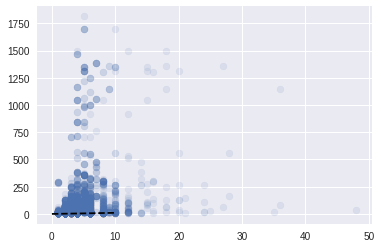

In [10]:
temp = np.linspace(0,10,10)

plt.scatter(y_test,pred_vals_lr_log, alpha = .1)
plt.plot(temp,temp,'k--')

In [11]:
sorted(zip(X.columns,abs(model_lr_log.coef_)), key=lambda x: -x[1])

[('rains', 1.8250323093366789),
 ('light_snow', 1.6066141589528602),
 ('light_rains', 1.0041995658335026),
 ('Visibility', 0.28142802130867473),
 ('Pressure', 0.25065901255207584),
 ('Conditions_Haze', 0.15520031642990323),
 ('Temp.', 0.031236271417541702),
 ('Dew Point', 0.027571891321805569),
 ('snow', 0.0)]

### R-Square for Linear Regression

In [13]:
model_lr_log.score(X_test, y_test)

0.19458312125872446

## Random Forest 

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Initializing model with hundred trees, one forest and 8 leafs
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=8, random_state=1)
# Fitting the model
model.fit(X_train, y_train)
# MAking predictions
predictions = model.predict(X_test)
# Compute the mean_squared_error
mean_squared_error(predictions, y_test)

2.7557937487132009

### R-Square for Random Forest

In [15]:
model.score(X_test, y_test)

0.37068616749301009

## Lasso Model

In [16]:
alphavec = 10**np.linspace(-3,9,2)
lasso_model = LassoCV(alphas = alphavec, cv =2)
lasso_model.fit(X_train, y_train)
pred_vals_lr_log = np.exp(lasso_model.predict(X_test))
RMSE_lr_log = np.sqrt(np.sum((pred_vals_lr_log - y_test)**2)/len(y_test))
RMSE_lr_log

132.71544312996599

In [17]:
list(zip(x,lasso_model.coef_))

[('Visibility', -0.29373157535800076),
 ('Dew Point', 0.027529903432761238),
 ('Pressure', -0.2321114783063741),
 ('Temp.', -0.031499525308617729),
 ('snow', 0.0),
 ('rains', 1.7140672375918806),
 ('light_snow', 1.3530515537149781),
 ('light_rains', 0.9097605657777178),
 ('Conditions_Haze', -0.16277495500501041)]

In [18]:
test_set_pred3 = lasso_model.predict(X_test.loc[:,x])

In [19]:
np.sqrt(np.mean((test_set_pred3 - y_test)**2))

1.8779923074823659

### R-Square for Lasso Model

In [20]:
lasso_model.score(X_test, y_test)

0.19460637970600247